In [6]:
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.engine import Layer
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard 
from keras.models import Sequential, Model
from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline
seed=42

In [7]:
from numpy.random import seed
seed(42)
from tensorflow.random import set_seed
set_seed(42)

In [8]:
#loading image data
imageData=[]

for filename in os.listdir('Train/'):
    imageData.append(img_to_array(load_img('Train/'+filename)))

imageData=np.array(imageData,dtype=float)
imageData=imageData/255.    

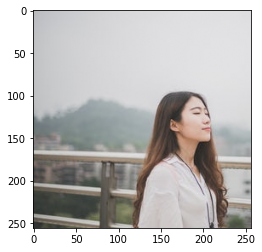

In [9]:
plt.imshow(imageData[0])

In [10]:
inception = InceptionResNetV2(weights='imagenet', include_top=True)
inception.graph = tf.compat.v1.get_default_graph()
# inception_not_top=InceptionResNetV2(weights='imagenet',include_top=False)

In [11]:
input_shape=(256,256,1)
# leaky_relu=LeakyReLU(alpha=0.1)

In [12]:
#encoder
encoder_input=Input(shape=input_shape)


conv1=Conv2D(64,(3,3),activation='relu',padding='same',strides=2)(encoder_input)
conv1=Conv2D(64,(3,3),activation='relu',padding='same')(conv1)
batch_norm1=BatchNormalization()(conv1)

conv2=Conv2D(128,(3,3),activation='relu',padding='same',strides=2)(batch_norm1)
conv2=Conv2D(128,(3,3),activation='relu',padding='same')(conv2)
batch_norm2=BatchNormalization()(conv2)

conv3=Conv2D(256,(3,3),activation='relu',padding='same',strides=2)(batch_norm2)
conv3=Conv2D(256,(3,3),activation='relu',padding='same')(conv3)
batch_norm3=BatchNormalization()(conv3)

conv4=Conv2D(512,(3,3),activation='relu',padding='same')(batch_norm3)
conv4=Conv2D(512,(3,3),activation='relu',padding='same')(conv4)
batch_norm4=BatchNormalization()(conv4)

conv5=Conv2D(256,(3,3),activation='relu',padding='same')(batch_norm4)
conv5=Conv2D(256,(3,3),activation='relu',padding='same')(conv5)

print(conv5.shape)

(None, 32, 32, 256)


<h5>The inception network gives us a 1000*1 dimensional vector which gives us the probability of an image belonging to particular class. We will repeat this vector 32*32 (conv5 layer output dimension) times to creat a 32*32 dimensional layer with 1000 channels which will give us the probability of a pixel belonging to a particular class and hence the color of that class</h5>

In [13]:
embed_input=Input(shape=(1000,))


#fusion
fusion_output=RepeatVector(1024)(embed_input)
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([conv5, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)

In [14]:
conv6=Conv2D(128,(3,3),activation='relu',padding='same')(fusion_output)
conv6=Conv2D(128,(3,3),activation='relu',padding='same')(conv6)
batch_norm_decoder1=BatchNormalization()(conv6)
# upsample1=UpSampling2D((2,2))(batch_norm_decoder1)
conv_transpose1=Conv2DTranspose(128,(3,3),padding='same',activation='relu',strides=2)(conv6)

conv7=Conv2D(64,(3,3),activation='relu',padding='same')(conv_transpose1)
conv7=Conv2D(64,(3,3),activation='relu',padding='same')(conv7)
batch_norm_decoder2=BatchNormalization()(conv7)
conv_transpose2=Conv2DTranspose(64,(3,3),padding='same',activation='relu',strides=2)(conv7)
# upsample2=UpSampling2D((2,2))(batch_norm_decoder2)

conv8=Conv2D(32,(3,3),activation='relu',padding='same')(conv_transpose2)
conv8=Conv2D(32,(3,3),activation='relu',padding='same')(conv8)
batch_norm_decoder3=BatchNormalization()(conv8)

conv9=Conv2D(16,(3,3),activation='relu',padding='same')(batch_norm_decoder3)
conv10=Conv2D(2,(3,3),activation='tanh',padding='same')(conv9)

decoder_output=Conv2DTranspose(2,(3,3),padding='same',activation='relu',strides=2)(conv10)

# decoder_output=UpSampling2D((2,2))(conv10)


alpha_model=Model(inputs=[encoder_input,embed_input],outputs=decoder_output)

In [38]:

print(upsample1.shape,conv_transpose1.shape)

print(upsample2.shape,conv_transpose2.shape)
print(decoder_output.shape)

(None, 64, 64, 128) (None, 64, 64, 128)
(None, 128, 128, 64) (None, 128, 128, 64)
(None, 256, 256, 2)


In [23]:
# alpha_model.summary()

<h4>
To create a fusion layer input,we have to create inception network embedding
which is given as an input to the fusion layer to concatenate with encoder output
</h4>

In [15]:
def createInceptionEmbedding(image_grayscale):
    # data : grayscaled rgb image resized
    data=[]
    for image in image_grayscale:
        image=resize(image,(299,299,3),mode='constant')
        data.append(image)
    data=np.array(data)
    # preprocessing the data in accordance with inception network
    data=preprocess_input(data)
    #print(data.shape)
    embed=inception.predict(data)
    #print(embed.shape)
    return embed

In [40]:
bb=[imageData[0]]
bb=np.array(bb)
check=createInceptionEmbedding(gray2rgb(rgb2gray(bb)))
print(check.shape)

(1, 1000)


In [16]:
datagen=ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    horizontal_flip=True
)

In [17]:
def lab_image_gen(batch_size=8,x_train=imageData):
    for batch in datagen.flow(x_train,batch_size=batch_size):
        inception_input=gray2rgb(rgb2gray(batch))
        embed=createInceptionEmbedding(inception_input)
        
        lab_batch=rgb2lab(batch)
        X=lab_batch[:,:,:,0]
        Y=lab_batch[:,:,:,1:]/128
        X=X.reshape(X.shape+(1,))
        
        yield ([X, createInceptionEmbedding(inception_input)], Y)


In [18]:
alpha_model.compile(optimizer='rmsprop',loss='mse',metrics=['mse','msle','mae','accuracy'])
alpha_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_307 (Conv2D)             (None, 128, 128, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_308 (Conv2D)             (None, 128, 128, 64) 36928       conv2d_307[0][0]                 
__________________________________________________________________________________________________
batch_normalization_307 (BatchN (None, 128, 128, 64) 256         conv2d_308[0][0]                 
______________________________________________________________________________________________

In [44]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10,
                                     restore_best_weights=True,
                                     monitor='loss',
                                    verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint_model.h5',
                                       save_best_only=True,
                                       monitor='loss',
                                      verbose=1,min_lr=0.001),
#     tf.keras.callbacks.TensorBoard(log_dir='./logs',write_images=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,patience=5,monitor='loss')

#     tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,patience=5,monitor='loss')
]



In [19]:
# validation_data=imageData[840-int(len(imageData)*0.1):840]
# trainig_data=imageData[0:int(len(imageData)*0.9)]
# steps=trainig_data.shape[0]//batch_size
batch_size=10
steps=imageData.shape[0]//batch_size
epochs=100

In [39]:
# print(len(imageData),validation_data.shape)

In [48]:
history=alpha_model.fit(lab_image_gen(batch_size,imageData),
#                         validation_data=lab_image_gen(batch_size,validation_data),
                        epochs=epochs,verbose=1,
                        steps_per_epoch=steps,
                        shuffle=True,
                        callbacks=my_callbacks)

Epoch 1/100
84/84 [==============================] - 94s 1s/step - loss: 0.0122 - mse: 0.0122 - msle: 0.0074 - mae: 0.0753 - accuracy: 0.5311

Epoch 00001: loss improved from inf to 0.01139, saving model to checkpoint_model.h5
Epoch 2/100
84/84 [==============================] - 89s 1s/step - loss: 0.0106 - mse: 0.0106 - msle: 0.0061 - mae: 0.0714 - accuracy: 0.5296

Epoch 00002: loss improved from 0.01139 to 0.01017, saving model to checkpoint_model.h5
Epoch 3/100
84/84 [==============================] - 87s 1s/step - loss: 0.0107 - mse: 0.0107 - msle: 0.0057 - mae: 0.0699 - accuracy: 0.5347

Epoch 00003: loss improved from 0.01017 to 0.00979, saving model to checkpoint_model.h5
Epoch 4/100
84/84 [==============================] - 88s 1s/step - loss: 0.0099 - mse: 0.0099 - msle: 0.0050 - mae: 0.0689 - accuracy: 0.5450

Epoch 00004: loss improved from 0.00979 to 0.00952, saving model to checkpoint_model.h5
Epoch 5/100
84/84 [==============================] - 87s 1s/step - loss: 0.0096 

In [20]:
def plotAccuracyAndLoss(history):
#     plt.plot(history.history['accuracy'])
#     plt.plot(history.history['val_accuracy'])
#     plt.title('model accuracy')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'validation'], loc='upper left')
#     plt.show()
#     plt.savefig('./')

    # loss plot
#     plt.plot(history.history['loss'])
    plt.plot(history.history['mse'])
    plt.plot(history.history['msle'])
    plt.plot(history.history['mae'])
    plt.plot(history.history['accuracy'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
#     plt.legend(['train', 'validation'], loc='upper left')
    plt.legend(['loss','mlse','mae','accuracy'],loc='upper left')
#     plt.savefig('./')
    plt.show()

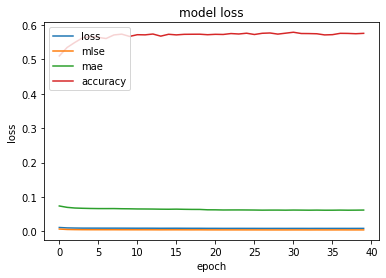

In [50]:
plotAccuracyAndLoss(history)

In [21]:
from keras.models import load_model

alpha_model=load_model('checkpoint_model.h5')
alpha_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_457 (Conv2D)             (None, 128, 128, 64) 640         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_458 (Conv2D)             (None, 128, 128, 64) 36928       conv2d_457[0][0]                 
__________________________________________________________________________________________________
batch_normalization_425 (BatchN (None, 128, 128, 64) 256         conv2d_458[0][0]                 
____________________________________________________________________________________________

In [22]:
train_subset=imageData
original=train_subset
gray_subset=gray2rgb(rgb2gray(train_subset))
train_subset_embed=createInceptionEmbedding(gray_subset)
train_subset=rgb2lab(train_subset)[:,:,:,0]
train_subset=train_subset.reshape(train_subset.shape+(1,))

output_subset=alpha_model.predict([train_subset,train_subset_embed])
output_subset=output_subset*128


In [26]:
def plot_imgs(bw , arr):
    fig = plt.figure(figsize=(8,50))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    i=0
    for i in range(min(len(arr),200)):
        ax = fig.add_subplot(50, 8, i + 1, xticks=[], yticks=[])
        i=i+1
        cur = np.zeros((256, 256, 3))
        cur[:,:,0] = bw[i-1][:,:,0]
        cur[:,:,1:] = arr[i-1]
        cur=lab2rgb(cur)
        plt.imshow(cur,cmap='gray')
    plt.show()

def plot_original_imgs(original):
    fig = plt.figure(figsize=(8,50))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(min(len(original),200)):
        ax = fig.add_subplot(50, 8, i + 1, xticks=[], yticks=[])
        i=i+1
        img=original[i-1]
        plt.imshow(img,cmap='gray')
    plt.show()

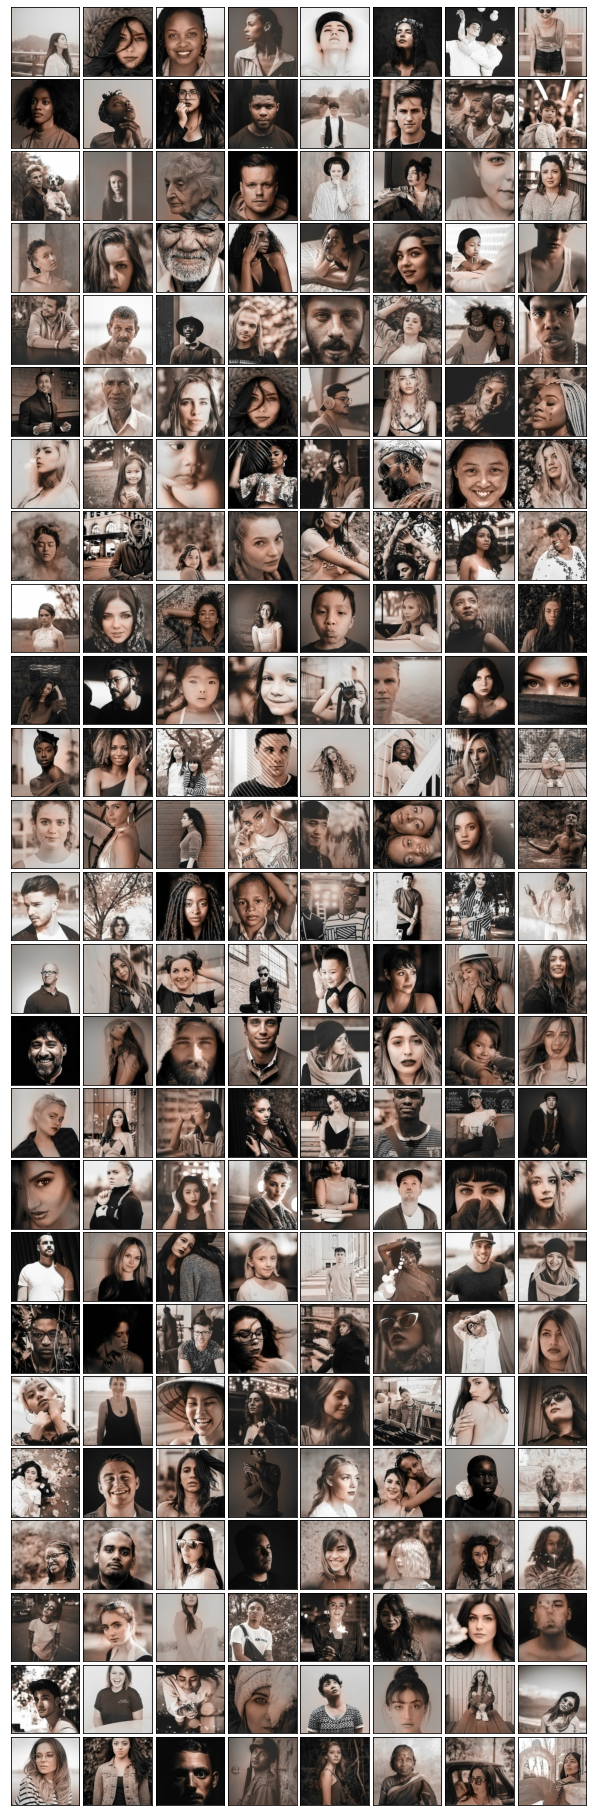

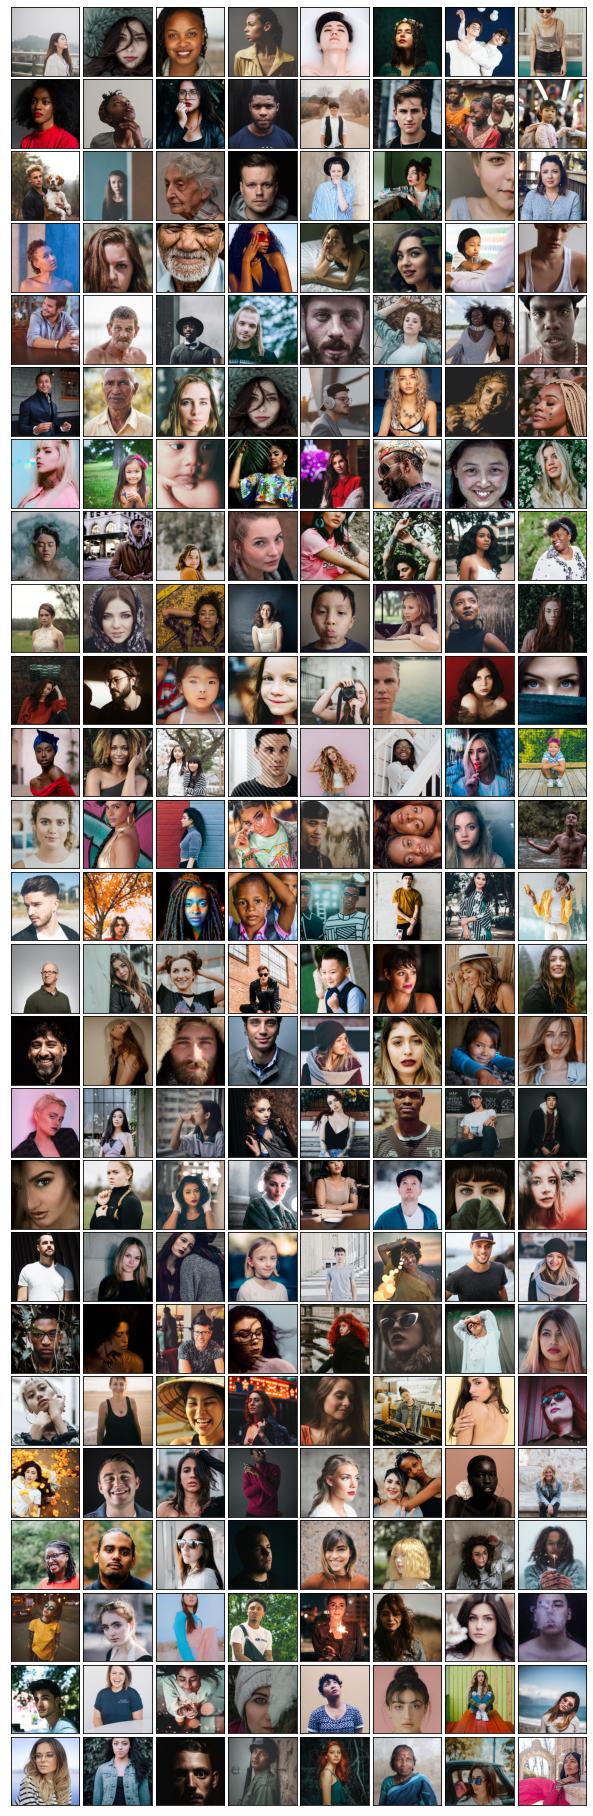

In [27]:
plot_imgs(train_subset,output_subset)
plot_original_imgs(original)

In [28]:
#testing

color_me = []
for filename in os.listdir('Test/'):
    color_me.append(img_to_array(load_img('Test/'+filename)))
color_me = np.array(color_me, dtype=float)
original_test=color_me/255.
gray_me = gray2rgb(rgb2gray(1.0/255*color_me))
color_me_embed = createInceptionEmbedding(gray_me)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))


# Test model
output = alpha_model.predict([color_me, color_me_embed])
output = output * 128

# Output colorizations
# for i in range(len(output)):
#     cur = np.zeros((256, 256, 3))
#     cur[:,:,0] = color_me[i][:,:,0]
#     cur[:,:,1:] = output[i]
#     imsave("result/img_"+str(i)+".png", lab2rgb(cur))

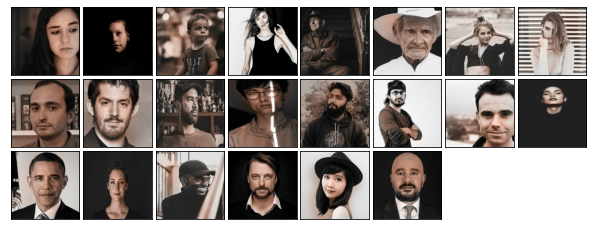

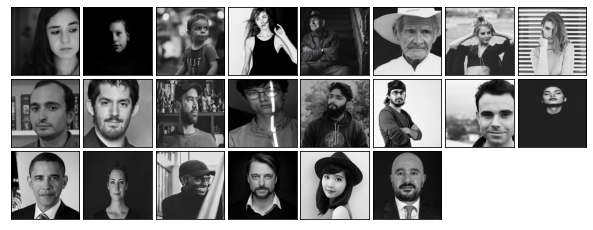

In [29]:
plot_imgs(color_me,output)
plot_original_imgs(original_test)

In [38]:
#Saving Model
alpha_model.save('Alpha_Model_Brownish_Output.h5')
alpha_model_json = alpha_model.to_json()
with open("alpha_model.json", "w") as json_file:
    json_file.write(alpha_model_json)

In [37]:
# Output colorizations
def save_imgs(path,output,inp):
    if(os.path.exists(path)==False):
        os.mkdir(path)
    for i in range(len(output)):
        cur = np.zeros((256, 256, 3))
        cur[:,:,0] = inp[i][:,:,0]
        cur[:,:,1:] = output[i]
        cur=lab2rgb(cur)
        if(i<5):
            plt.imshow(cur,cmap='gray')
        filepath=path+str(i)+'.png'
        plt.imsave(filepath,cur)

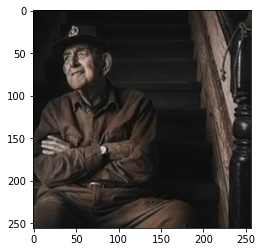

In [36]:
save_imgs("train_images_result_alpha/",output_subset,train_subset)
save_imgs("test_images_result_alpha/",output,color_me)